<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Import-libraries-and-functions" data-toc-modified-id="Import-libraries-and-functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import libraries and functions</a></span></li><li><span><a href="#Set-some-parameters" data-toc-modified-id="Set-some-parameters-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Set some parameters</a></span></li><li><span><a href="#Import-the-data" data-toc-modified-id="Import-the-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Import the data</a></span></li><li><span><a href="#Drop-the-canceled-and-rejected-jobs" data-toc-modified-id="Drop-the-canceled-and-rejected-jobs-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Drop the canceled and rejected jobs</a></span></li></ul></li><li><span><a href="#Decisions" data-toc-modified-id="Decisions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Decisions</a></span><ul class="toc-item"><li><span><a href="#Decide-on-what-basis-to-assign-fiscal-year" data-toc-modified-id="Decide-on-what-basis-to-assign-fiscal-year-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Decide on what basis to assign fiscal year</a></span></li><li><span><a href="#Decide-whether-to-look-at-PMs-or-CMs" data-toc-modified-id="Decide-whether-to-look-at-PMs-or-CMs-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Decide whether to look at PMs or CMs</a></span></li><li><span><a href="#Check-out-the-most-numerous-problem-types" data-toc-modified-id="Check-out-the-most-numerous-problem-types-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Check out the most numerous problem types</a></span></li></ul></li><li><span><a href="#Compute-the-KPI-and-visualize" data-toc-modified-id="Compute-the-KPI-and-visualize-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Compute the KPI and visualize</a></span><ul class="toc-item"><li><span><a href="#Aggregate-by-the-the-fiscal-year" data-toc-modified-id="Aggregate-by-the-the-fiscal-year-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Aggregate by the the fiscal year</a></span></li></ul></li></ul></div>

# Interactive Notebook for FMD KPIs

## Setup

### Import libraries and functions


In [1]:
# workhorse modules
import pandas as pd
from datetime import timedelta, datetime
from pathlib import Path
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# local utility functions
from utils.general_utils import (
    add_fiscal_year,
    compute_is_on_time,
    set_pd_params,
    choose_pms_or_cms,
    compute_pm_cm,
    compute_pm_cm_by_month,
    compute_kpi_table,
    compute_kpi_table_by_month,
)
from utils.vis_utils import set_plot_params, pointplot_with_barplot

### Set some parameters

In [2]:
set_pd_params()
set_plot_params(12, 6)
pd.options.mode.chained_assignment = None  # default='warn'

### Import the data

In [3]:
scorecard_path = Path.cwd() / "data" / "scorecard_data.pkl"
wr_tidy = pd.read_pickle(scorecard_path)

### Drop the canceled and rejected jobs

In [32]:
# drop rows that were canceled
cond_valid = ~wr_tidy["status"].isin(["Can", "Rej", "R"])

wr_valid = wr_tidy[cond_valid]

print(
    f"By dropping canceled and rejected work orders, we have removed {len(wr_tidy) - len(wr_valid):,} rows."
)

## Decisions

### Decide on what basis to assign fiscal year
Use the dropdown menu to decide on what basis to assign the fiscal year. 

In [17]:
wr_fy_widget = interactive(
    add_fiscal_year,
    assign_fy_on=["Requested", "Completed", "Closed"],
    df=fixed(wr_valid),
)
wr_fy_widget

interactive(children=(Dropdown(description='assign_fy_on', index=2, options=('Requested', 'Completed', 'Closed…

In [26]:
fy_assignment = wr_fy_widget.children[0].value
wr_fy = wr_fy_widget.result

### Decide whether to look at PMs or CMs

In [27]:
wr_typed_widget = interactive(
    choose_pms_or_cms,
    selection=["PMs", "CMs", "All WRs"],
    df=fixed(wr_fy),
)

wr_typed_widget

interactive(children=(Dropdown(description='selection', options=('PMs', 'CMs', 'All WRs'), value='PMs'), Outpu…

In [40]:
selection = wr_typed_widget.children[0].value
wr_typed = wr_typed_widget.result
print(f"The dataframe containing {selection} has {len(wr_typed):,} rows.")

The dataframe containing CMs has 87,950 rows.


### Check out the most numerous problem types
This helps us do a sanity check and understand what data we're looking at.

In [41]:
wr_typed["problem_type"].value_counts().nlargest(6)

HVAC              13555
OTHER             13034
SERV/CUSTODIAL     7965
ELEC/LIGHT         5510
_DELIVERY          3962
PLUMB/OTHER        3955
Name: problem_type, dtype: int64

## Compute the KPI and visualize

### Aggregate by the the fiscal year

In [42]:
compliance = compute_kpi_table(
    wr_typed,
    f"percent_{selection}_on_time",
    f"total_{selection}",
    grouping_var="fiscal_year",
)
compliance

,percent_CMs_on_time,total_CMs
fiscal_year,,
2014,75.36,9849
2015,76.56,13825
2016,77.98,15312
2017,69.85,15052
2018,68.21,12943
2019,50.27,9012
2020,47.87,7668
2021,42.18,4289


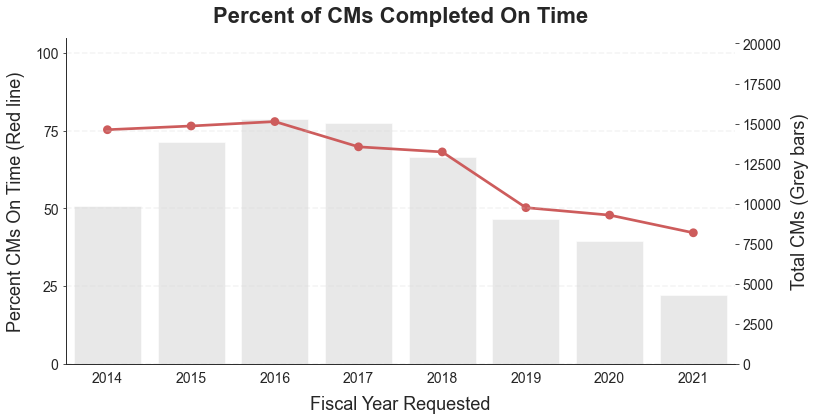

In [43]:
pointplot_with_barplot(
    compliance,
    x=compliance.index,
    point_y=f"percent_{selection}_on_time",
    bar_y=f"total_{selection}",
    xlabel=f"Fiscal Year {fy_assignment}",
    ylabel_point=f"Percent {selection} On Time (Red line)",
    ylabel_bar=f"Total {selection} (Grey bars)",
    title=f"Percent of {selection} Completed On Time",
)